<Figure size 720x504 with 0 Axes>

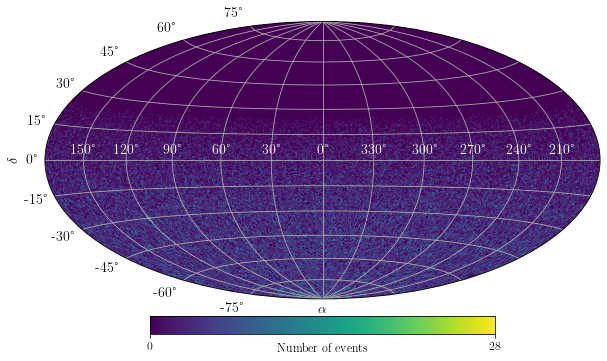

In [1]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

#to work with time and angular coordinates in the celeastial sphere
from astropy.time import Time

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4):
    
    alpha = df[str1].to_numpy()
    delta = df[str2].to_numpy()
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i]])
        
    return evt_list

#convert to healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#compute the 
#-------------------------------
# main 
#-------------------------------

#save dataframe with event info from csv file
path = '../DataSets/MockData_Repeaters/'
filename = 'TimeOrdered_Events_ExponentialRepeater_Date_2015-01-01T00:00:00_Period_86164_TotalEvents_100000_AcceptedRepEvents_100.parquet'

uniform_dist_data = pd.read_parquet(path + filename, engine='fastparquet') 

#convert dataframe into a list of events
uniform_dist_events = pandas_to_event(uniform_dist_data,"rep_ud_ra", "rep_ud_dec","rep_ud_gpstime","rep_ud_energy")    

#change delta into colatitude to project in sky
hp_ud_events = Healpy_Event(uniform_dist_events)


#12*nside*nside gives the number of pixels of sphere 
NSIDE = 64
            
#vector with index positions in healpy sky_map given theta and phi
cr_sky_indexes = [] 

#vector to hold events. If the event is accepted, the vector is field with 1, otherwise it is filed with 0
events = []

#run over the events 
for evt in hp_ud_events:
    
    cr_sky_indexes.append(hp.ang2pix(NSIDE,evt[1],evt[0]))
    events.append(1)

#count map for each event: vector with size npix and filled with 0s
instant_cr_sky = np.zeros(hp.nside2npix(NSIDE))

#subsitutes zeros in the pixel indices for their bin content, given the data
np.add.at(instant_cr_sky, cr_sky_indexes, events)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    instant_cr_sky,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('skymap_repeater.pdf',dpi=500)



<Figure size 720x504 with 0 Axes>

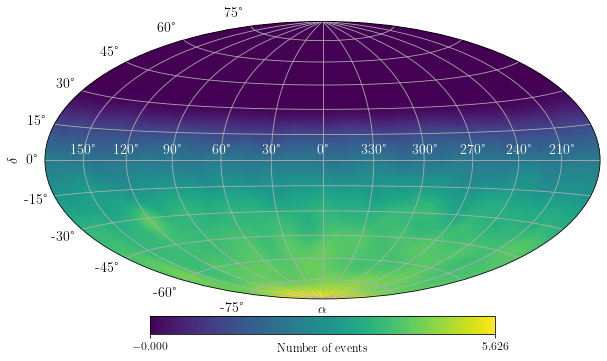

In [2]:
smoothing_radius = np.radians(10)

smooth_sky_map = hp.smoothing(instant_cr_sky, sigma=0.5*smoothing_radius)
#create figure
fig_smooth = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    smooth_sky_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 15,
    xtick_label_color='white'
)

plt.savefig('smooth_sky_map_repeater.pdf',dpi=500)

In [ ]:
#compute the total exposure and the integrated exposure per solid angle
def integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, station_array):

    #to select only the stations within the time period time_begin < time < time_end
    time_indexes = np.where(np.logical_and(time > time_begin, time < time_end))[0]

    return (math.pi/2)*(math.cos(2*theta_min) - math.cos(2*theta_max))*a_cell*sum(station_array[time_indexes])

#compute the relative exposure per solid angle
def relative_exposure(dec_array, lat_auger, theta_min, theta_max):
    
    exposure = []
    
    for dec in dec_array:
        
        xi = (math.cos(theta_max) - math.sin(lat_auger)*math.cos(dec))/(math.cos(lat_auger)*math.cos(dec))
        
        if ( xi > 1):
            h_max = 0
        else if (xi < -1):
            h_max = math.pi
        else:
            h_max = math.acos(xi)
        
        exposure.append(math.cos(lat_auger)*math.cos(dec)*math.sin(h_max) + h_max*math.sin(lat_auger)*math.sin(dec))
        
    return rel_exposure = np.divide(exposure,sum(exposure))

#
#values of the maximum and minimum values of theta. In this case we are considering vertical events
theta_min = math.radians(0)
theta_max = math.radians(60)

#set value of unit cell of array according to distance between stations
d = 1.5 #in kilometers
a_cell = .5*math.sqrt(3)*d*d

#set time interval in seconds
time_begin = Time('2004-01-01T00:00:00', format='fits').gps
time_end = Time('2016-08-31T23:59:59', format='fits').gps

#load station data
station_data = pd.read_parquet('../input/Hexagons_NoBadStations.parquet', engine='fastparquet')

time = station_data['gps_time'].to_numpy()
#time = station_data.index.to_numpy()
n5T5 = station_data['n5T5'].to_numpy()
n6T5 = station_data['n6T5'].to_numpy()

#compute time integrated exposure
total_exposure = integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, n5T5 + n6T5)/(365*24*60) #per year per sr per km^2
